In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
from tqdm.auto import tqdm
from time_series import create_time_series
sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))
import fsrs_optimizer
import numpy as np

tqdm.pandas()

In [2]:
# Review count: User id
# Median: 8798
# Most: 6810

df = pd.read_parquet(
    "../anki-revlogs-10k/revlogs", filters=[("user_id", "=", 8798), ("rating", "in", [1, 2, 3, 4])], columns=["card_id", "day_offset", "rating", "elapsed_days"] 
)
df.size

123980

In [3]:
df.describe()

,card_id,day_offset,rating,elapsed_days
count,30995.000000,30995.000000,30995.000000,30995.000000
mean,1638.717471,1128.021520,2.430457,16.666495
std,1016.531874,1309.453886,0.858003,62.670347
min,0.000000,0.000000,1.000000,-1.000000
25%,649.000000,63.000000,2.000000,0.000000
50%,1551.000000,230.000000,3.000000,2.000000
75%,2668.000000,2528.000000,3.000000,7.000000
max,3209.000000,3692.000000,4.000000,3432.000000


In [4]:
df[df["card_id"] == 230]

,card_id,day_offset,rating,elapsed_days
1740,230,7,1,-1
1741,230,7,3,0
1742,230,7,3,0
1743,230,8,1,1
1744,230,8,3,0
1745,230,9,3,1
1746,230,11,3,2
1747,230,14,4,3
1748,230,21,3,7
1749,230,39,3,18


In [5]:
df["prior_reviews"] = df.groupby("day_offset").cumcount()

In [6]:
print("creating time series")
df["delta_t"] = df["elapsed_days"]
df: pd.DataFrame = create_time_series(df)
print("training")
trainer = fsrs_optimizer.Trainer(df, df, fsrs_optimizer.DEFAULT_PARAMETER)
w = trainer.train()

creating time series
training


train:   0%|          | 0/17900 [00:00<?, ?it/s]

iteration: 1792
w: [0.3637, 1.183, 3.1356, 15.6541, 7.1752, 0.5445, 1.5062, 0.001, 1.5492, 0.1326, 1.0199, 1.9271, 0.12, 0.2735, 2.2775, 0.232, 3.041, 0.4744, 0.6277]
iteration: 3584
w: [0.3135, 1.1636, 3.1354, 15.6398, 7.1894, 0.5567, 1.5469, 0.001, 1.5348, 0.1259, 1.0035, 1.8861, 0.1591, 0.2298, 2.2473, 0.2036, 3.0397, 0.476, 0.5791]
iteration: 5376
w: [0.2822, 1.1555, 3.1333, 15.6278, 7.1987, 0.5648, 1.5615, 0.013, 1.5368, 0.1256, 1.0061, 1.8753, 0.167, 0.2164, 2.2265, 0.2308, 3.0301, 0.4496, 0.5734]
iteration: 7168
w: [0.2631, 1.161, 3.1307, 15.6166, 7.2125, 0.558, 1.5757, 0.0241, 1.5351, 0.133, 1.0056, 1.8945, 0.1463, 0.233, 2.2344, 0.2574, 3.0214, 0.4392, 0.5819]
iteration: 8960
w: [0.2481, 1.1651, 3.1251, 15.6035, 7.2238, 0.542, 1.594, 0.0226, 1.5263, 0.1428, 0.9979, 1.9012, 0.139, 0.2372, 2.2284, 0.2655, 3.0086, 0.4445, 0.583]
iteration: 10752
w: [0.2265, 1.1648, 3.123, 15.5939, 7.2364, 0.5312, 1.6087, 0.0179, 1.5158, 0.1408, 0.9875, 1.9037, 0.1363, 0.2389, 2.228, 0.2634, 3.001

In [7]:
import math

DECAY = -0.5
FACTOR = 0.9 ** (1 / DECAY) - 1

def power_forgetting_curve(t, s):
    return (1 + FACTOR * t / s) ** DECAY

def stability_after_success(s, r, d, rating):
    hard_penalty = w[15] if rating == 2 else 1
    easy_bonus = w[16] if rating == 4 else 1
    return max(
        0.01,
        s * (
            1
            + math.exp(w[8])
            * (11 - d)
            * (s ** -w[9])
            * (math.exp((1 - r) * w[10]) - 1)
            * hard_penalty
            * easy_bonus
        )
    )

def stability_after_failure(s, r, d):
    return max(
        0.01,
        min(
            w[11]
            * (d ** -w[12])
            * ((s + 1) ** w[13] - 1)
            * math.exp((1 - r) * w[14]),
            s / math.exp(w[17] * w[18])
        )
    )

def stability_short_term(s, init_rating=None):
    if init_rating is not None:
        rating_offset = fsrs_optimizer.DEFAULT_FIRST_RATING_OFFSETS[init_rating - 1]
        session_len = fsrs_optimizer.DEFAULT_FIRST_SESSION_LENS[init_rating - 1]
    else:
        rating_offset = fsrs_optimizer.DEFAULT_FORGET_RATING_OFFSET
        session_len = fsrs_optimizer.DEFAULT_FORGET_SESSION_LEN
    
    new_s = s * math.exp(
        w[17] * (rating_offset + session_len * w[18])
    )
    return new_s

def init_d(rating):
    return w[4] - math.exp(w[5] * (rating - 1)) + 1

def init_d_with_short_term(rating):
    rating_offset = fsrs_optimizer.DEFAULT_FIRST_RATING_OFFSETS[rating - 1]
    new_d = init_d(rating) - w[6] * rating_offset
    return max(1, min(new_d, 10))

def linear_damping(delta_d, old_d):
    return delta_d * (10 - old_d) / 9

def mean_reversion(init, current):
    return w[7] * init + (1 - w[7]) * current

def next_d(d, rating):
    delta_d = -w[6] * (rating - 3)
    new_d = d + linear_damping(delta_d, d)
    new_d = mean_reversion(init_d(4), new_d)
    return max(1, min(new_d, 10))


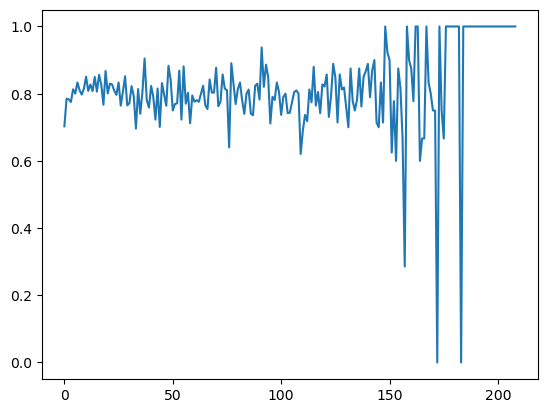

In [8]:
mean = df.groupby("prior_reviews")["y"].mean()
plt.plot(mean)
plt.show()

In [9]:
def memory_state(df):
    t_history = [int(t) for t in df["t_history"].split(",")]
    r_history = [int(r) for r in df["r_history"].split(",")]
    difficulty = None
    stability = None
    retrievability = 1e-10
    for delta_t, rating in zip(t_history, r_history):
        if stability is None:  # New card
            difficulty = init_d_with_short_term(rating)
            stability = stability_short_term(w[rating - 1], init_rating=rating)
        else:
            retrievability = power_forgetting_curve(delta_t, stability)
            if rating > 1:
                stability = stability_after_success(
                    stability, retrievability, difficulty, rating
                )
            else:
                stability = stability_after_failure(stability, retrievability, difficulty)
                stability = stability_short_term(stability)
            difficulty = next_d(difficulty, rating)
            if rating == 1:
                difficulty -= (w[6] * fsrs_optimizer.DEFAULT_FORGET_RATING_OFFSET)
                difficulty = min(max(difficulty, 1), 10)

    return stability, difficulty, retrievability


df["s"], df["d"], df["r"] = zip(*df.progress_apply(memory_state, axis=1))

  0%|          | 0/17900 [00:00<?, ?it/s]

In [10]:
df["loss"] = df.apply(lambda df: (df["y"] - df["r"]) ** 2, axis=1)

Average Very Young cards per day 40.577319587628864


<Figure size 640x480 with 0 Axes>

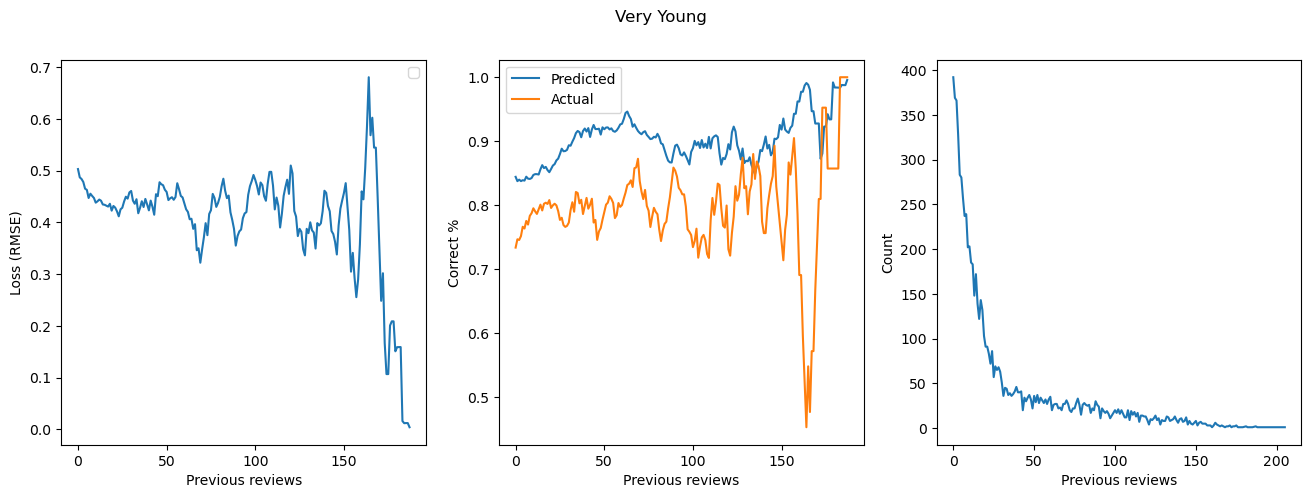

Average Young cards per day 68.36224489795919


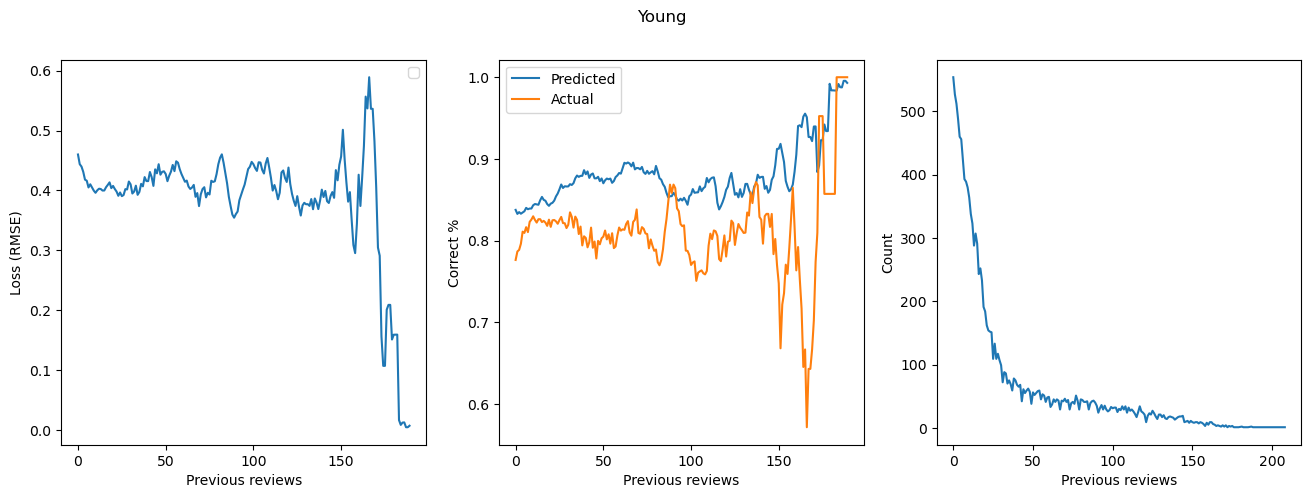

Average Mature cards per day 23.017964071856287


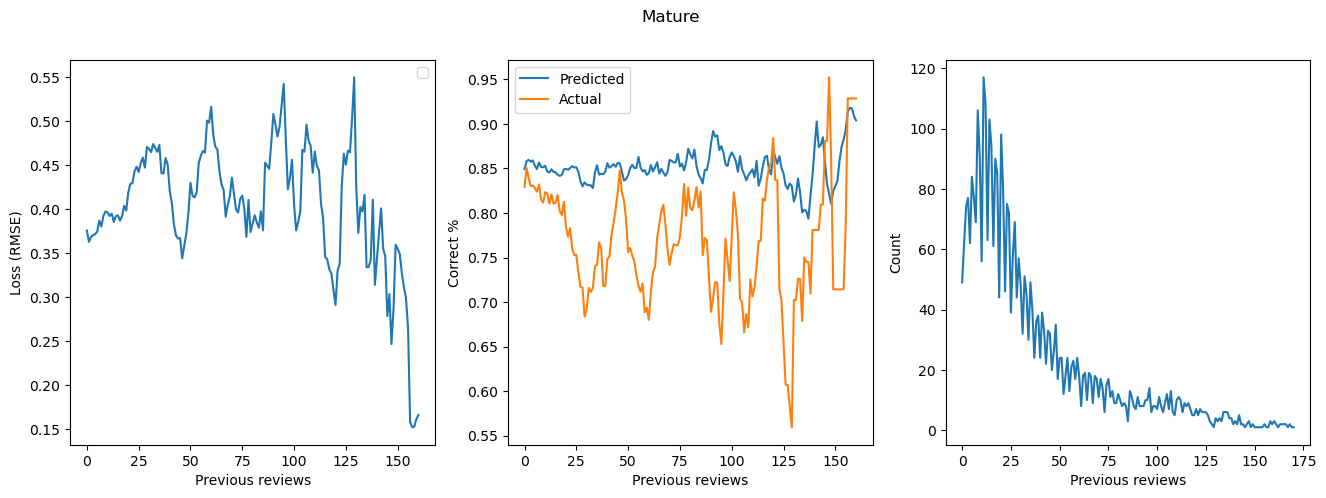

Average All cards per day 87.97448979591837


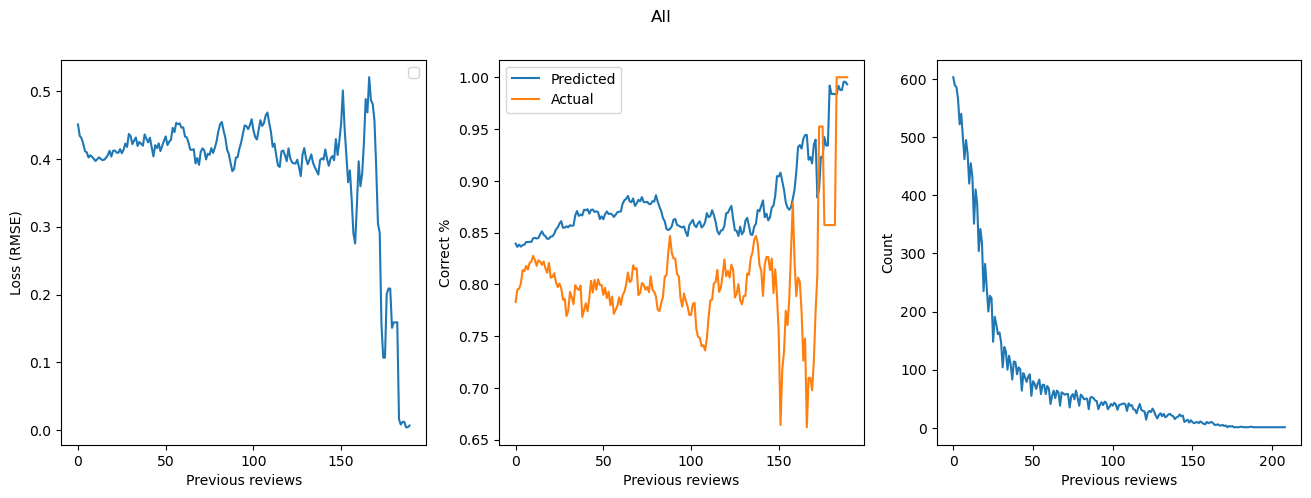

In [11]:
plt.clf()
categories = [
    #("Learn", -1, 1), 
    ("Very Young", 0, 4), 
    ("Young", 0, 21), 
    ("Mature", 21, 1e20),
    ("All", -1, 1e20)
]

# https://stackoverflow.com/a/54628145/24162642
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

for name, lower, upper in categories:
    df_filtered = df[(df["elapsed_days"] > lower) & (df["elapsed_days"] <= upper) & (df["r"] > 1e-9)].groupby("prior_reviews")

    print(f"Average {name} cards per day {df_filtered['card_id'].count().mean()}")
    loss = df_filtered["loss"].mean() ** 0.5
    loss = moving_average(loss, 7)

    fig = plt.figure(figsize=(16, 5))
    fig.suptitle(name)
    ax1 = fig.add_subplot(131)

    ax1.set_xlabel('Previous reviews')
    ax1.set_ylabel('Loss (RMSE)')
    ax1.plot(loss)
    ax1.legend()

    ax2 = fig.add_subplot(132)

    ax2.plot(moving_average(df_filtered["r"].mean(), 7), label="Predicted")
    ax2.plot(moving_average(df_filtered["y"].mean(), 7), label="Actual")
    ax2.set_xlabel('Previous reviews')
    ax2.set_ylabel('Correct %')
    ax2.legend()

    ax3 = fig.add_subplot(133)

    ax3.plot(df_filtered["r"].count())
    ax3.set_xlabel('Previous reviews')
    ax3.set_ylabel('Count') # Number of days that the user had that many reviews or more

    plt.show()
